In [1]:
import nidaqmx
import nidaqmx.stream_readers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import csv
from scipy import stats
import os

In [2]:
# -- Plotting Functions --

# Plot only voltage data - Galvo Waveform
def plot_galvo(title, xlabel, ylabel, data):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(data) 

# Plot scatterplot - X and Y data
def plot_xy_scatter(title, xlabel, ylabel, xdata, ydata):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.scatter(xdata, ydata)

# Plot modifiable Line graph with multiple sets of data
def plot_line(xdata, y1, freq=None, title=None, xlabel="Time [s]", ylabel="Voltage [V]", 
              ylabel1=None, ylabel2=None, ylabel3=None, y2=None, y3=None, markers=None):
    fig, ax = plt.subplots()
    
    if title == None: # Default title
        if freq == None:
            ax.set_title("Galvo scanner response to command wave")
        else:
            ax.set_title("Galvo scanner response to command wave (" + str(freq) + "Hz)")
    else:
        ax.set_title(title)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
        
    if markers == None: # If markers are needed (for start and stop voltages - for y1 data only)
        if ylabel1 == None:
            ax.plot(xdata, y1)
        else:
            ax.plot(xdata, y1, label=ylabel1)
    else:
        if ylabel1 == None:
            ax.plot(xdata, y1, marker='o', markevery=markers)
        else:
            ax.plot(xdata, y1, label=ylabel1, marker='o', markevery=markers)
    
    if y2 is not None: # Plot multiple sets of data
        ax.plot(xdata, y2, label=ylabel2)
        if y3 is not None:
            ax.plot(xdata, y3, label=ylabel3)
        ax.legend()
    ax.plot()

# Plot CMD and POS up to 2500 samples
def plot_cmd_pos_zoom(t, cmd, pos):
    fig, ax = plt.subplots()
    ax.set_title("Galvo scanner response to command wave zoomed in")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Voltage [V]")
    ax.plot(t[:2500], cmd[:2500], label="cmd")
    ax.plot(t[:2500], pos[:2500], label="pos")
    ax.legend()

In [3]:
# -- CSV Functions -- 

# Write X and Y data to csv
def write_to_csv(name, x, y):
    file = open(name + ".csv", "w")
    writer = csv.writer(file)
    for w in range(len(cmd)):
        writer.writerow([x[w], y[w]])
    file.close()

# Write X, Y1, and Y2 data to csv
def write_to_csv2(name, t, cmd, pos):
    file = open(name + ".csv", "w")
    writer = csv.writer(file)

    for w in range(len(cmd)):
        writer.writerow([t[w], cmd[w], pos[w]])
    file.close()

# Read data from csv
def open_csv(filename):
    file = open(filename + ".csv")
    csvreader = csv.reader(file)
    t_list = []
    cmd_list = []
    pos_list = []
    for row in csvreader:
        if row:
            t_list.append(float(row[0]))
            cmd_list.append(float(row[1]))
            pos_list.append(float(row[2]))
    file.close()
    return t_list, cmd_list, pos_list

In [4]:
# -- Galvo Parameters --

zoom = 1
undershoot = 50
pixelsPerLine = 256 #100
linesPerFrame = 256 #100
X_RETRACE_LEN = 128

In [5]:
# -- Generating Waveform (taken and modified from OpenScan) --

# Generating X and Y retrace
def SplineInterpolate(n, yFirst, yLast, slopeFirst, slopeLast):
    m = float(n)
    mm = float(m * m)
    mmm = float(m * m *m)
    c = []
    c.append(slopeFirst / mm + 2.0 * yFirst / mmm + slopeLast / mm - 2.0 * yLast / mmm)
    c.append(3.0 * yLast / mm - slopeLast / m - 2.0 * slopeFirst / m - 3.0 * yFirst / mm)
    c.append(slopeFirst)
    c.append(yFirst)
    
    result = []
    n = int(n)
    for i in range(n):
        result.append(c[0] * i*i*i + c[1] * i*i + c[2] * i + c[3])
    return result

# Generating single X waveform (for 1 scan line)
def GenerateXWaveform(scanLen, retraceLen, undershootLen, scanStart, scanEnd):
    waveform = []
    scanAmp = scanEnd - scanStart
    step = scanAmp/scanLen
    linearLen = undershootLen + scanLen
    undershootStart = scanStart - undershootLen * step
    
    for i in range(linearLen):
        val = undershootStart + step * i
        waveform.append(val)
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, undershootStart, step, step)
        completeWaveform = waveform + splineWaveform
    return completeWaveform

# Generating complete Y waveform (for 1 frame)
def GenerateYWaveform(linesPerFrame, retraceLen, xLength, scanStart, scanEnd):
    scanAmp = scanEnd - scanStart
    step = scanAmp/linesPerFrame
    waveform = np.zeros(linesPerFrame * xLength)
    
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, scanStart, 0, 0)
    for j in range(linesPerFrame):
        for i in range(xLength):
            waveform[i + j * xLength] = scanStart + step * j
            nextIndex = i + j * xLength
            if j >= (linesPerFrame - 1) and i >= (xLength - X_RETRACE_LEN):
                break
    
    if retraceLen > 0:
        splineWaveform = SplineInterpolate(retraceLen, scanEnd, scanStart, 0, 0)
        for i in range(X_RETRACE_LEN):
            waveform[nextIndex + i] = splineWaveform[i]
    return waveform

# Generate complete galvo waveform (both X and Y)
def GenerateGalvoFrame(width, height, resolution, zoom, undershoot, xOffset, yOffset, galvoX, galvoY):
    xStart = (-0.5 * resolution + xOffset) / (zoom * resolution)
    yStart = (-0.5 * resolution + yOffset) / (zoom * resolution)
    xEnd = xStart + pixelsPerLine / (zoom * resolution)
    yEnd = yStart + linesPerFrame / (zoom * resolution)
    
    offsetXinDegree = galvoX / 3.0
    offsetYinDegree = galvoY / 3.0
    xLength = undershoot + pixelsPerLine + X_RETRACE_LEN
    yLength = linesPerFrame
    
    xWaveformFrame = GenerateXWaveform(pixelsPerLine, X_RETRACE_LEN, undershoot, xStart, xEnd)
    yWaveformFrame = GenerateYWaveform(linesPerFrame, X_RETRACE_LEN, xLength, yStart, yEnd)
    waveformFrame = np.zeros(2 * xLength * yLength)
    fullXWaveformFrame = []
    for j in range(yLength):
        for i in range(xLength):
            waveformFrame[i + j * xLength] = (xWaveformFrame[i] + offsetXinDegree)
            waveformFrame[i + j * xLength + yLength * xLength] = (yWaveformFrame[i + j * xLength] + offsetYinDegree)
    return waveformFrame
                

Number of samples: 222208


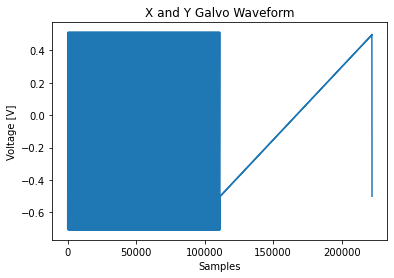

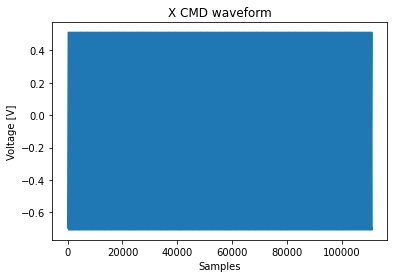

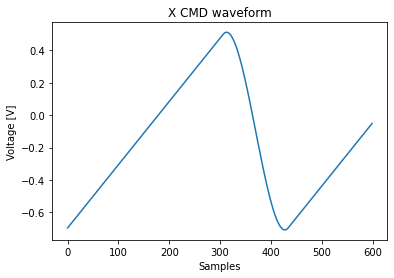

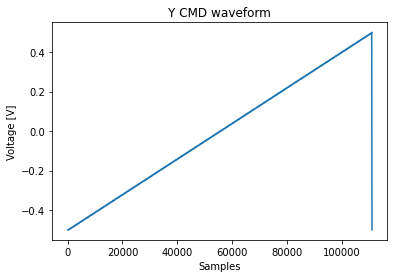

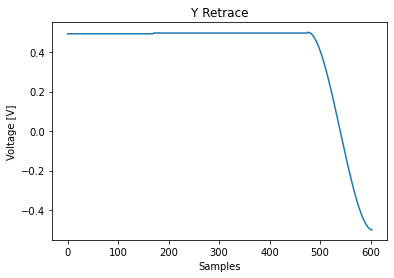

In [6]:
# Generate x and y waveform with default parameters
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)

# X and Y frame
frameLength = len(frame)
print("Number of samples: " + str(frameLength))
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)

# X frame
xFrame = frame[:int(frameLength / 2)]
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])

# Y frame
yFrame = frame[int(frameLength / 2):]
plot_galvo("Y CMD waveform", "Samples", "Voltage [V]", yFrame)
plot_galvo("Y Retrace", "Samples", "Voltage [V]", yFrame[110500:])

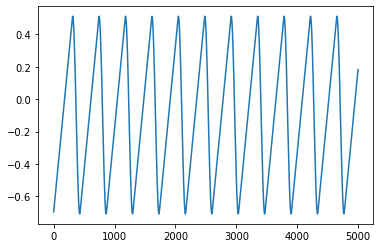

In [7]:
xFrame_waveform = xFrame[:5000] # Get first 5000 samples to write to scanner
plt.plot(xFrame_waveform)

In [8]:
# -- Scanner setting parameters --

device = "Dev1"
aichan = "ai0"
aochan = "ao0"

In [9]:
# -- Writing to Scanner --

# Getting position waveform
def get_pos_waveform(waveform_segments):
    pos_waveform = np.concatenate(waveform_segments)
    return pos_waveform

# Writing to scanner
def write_voltage_waveform(samp_rate, x_waveform):
    pos_waveform_segments = []  # list of 1D arrays
    
    # set parameters
    total_samples = 5000
#     duration = total_samples / samp_rate
#     t = np.linspace(0, duration, total_samples, endpoint=False)
    read_size = 1000  # samples
    cmd_waveform = x_waveform
    
    # Write to channels
    FINITE = nidaqmx.constants.AcquisitionType.FINITE
    with nidaqmx.Task() as intask:
        intask.ai_channels.add_ai_voltage_chan(f"{device}/{aichan}")
        intask.timing.cfg_samp_clk_timing(samp_rate, sample_mode=FINITE, samps_per_chan=total_samples)

        reader = nidaqmx.stream_readers.AnalogSingleChannelReader(intask.in_stream)
        def input_callback(task, event_type, n_samples, data):
            buffer = np.empty(n_samples)
            n_read = reader.read_many_sample(buffer, n_samples)
            pos_waveform_segments.append(buffer[:n_read])
            return 0
        intask.register_every_n_samples_acquired_into_buffer_event(read_size, input_callback)

        intask.triggers.start_trigger.cfg_dig_edge_start_trig(f"/{device}/ao/StartTrigger")
        intask.start()

        with nidaqmx.Task() as outtask:
            outtask.ao_channels.add_ao_voltage_chan(f"{device}/{aochan}")
            outtask.timing.cfg_samp_clk_timing(samp_rate, sample_mode=FINITE, samps_per_chan=total_samples)
            outtask.write(cmd_waveform, auto_start=True)
            outtask.wait_until_done()

        intask.wait_until_done()
        
    pos_waveform = get_pos_waveform(pos_waveform_segments)
    
    return t, cmd_waveform, pos_waveform

In [10]:
# -- Generating default voltage waveforms at different sampling rates (undershoot = 50, resolution = 256, retrace = 128) --


In [12]:
# t, cmd, pos = write_voltage_waveform(1e5, xFrame_waveform) # 1e5 rate
t, cmd, pos = open_csv("1e5_rate")

In [13]:
# t2, cmd2, pos2 = write_voltage_waveform(5e4, xFrame_waveform) # 5e4 rate
t2, cmd2, pos2 = open_csv("5e4_rate")

In [14]:
# t3, cmd3, pos3 = write_voltage_waveform(1.25e5, xFrame_waveform) # 1.25e5 rate
t3, cmd3, pos3 = open_csv("1_25e5_rate")

In [15]:
# t4, cmd4, pos4 = write_voltage_waveform(2e5, xFrame_waveform) # 2e5 rate
t4, cmd4, pos4 = open_csv("2e5_rate")

In [16]:
# t5, cmd5, pos5 = write_voltage_waveform(2.5e5, xFrame_waveform) # 2.5e5 rate
t5, cmd5, pos5 = open_csv("2_5e5_rate")

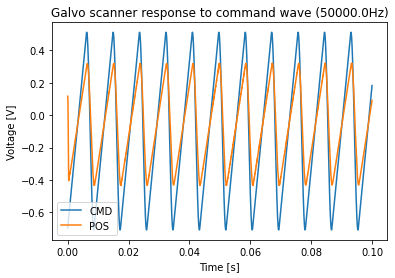

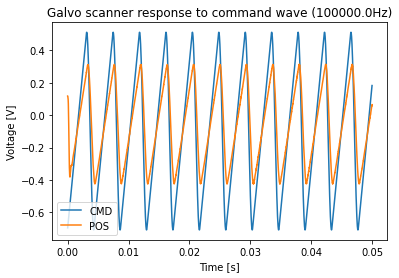

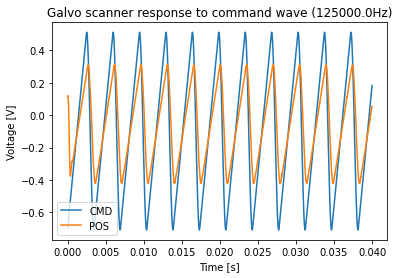

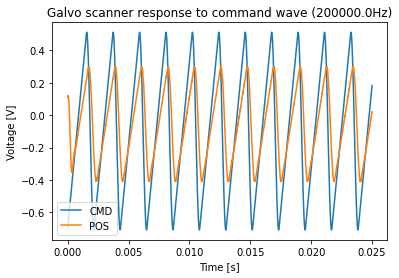

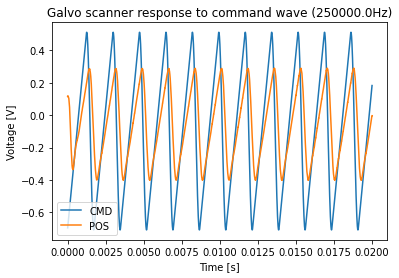

In [17]:
# CMD and POS Plots from 5e4 to 2.5e5 sampling rate
# (larger sampling rate = smaller duration)

plot_line(t2, cmd2, freq=5e4, ylabel1="CMD", ylabel2="POS", y2=pos2)
plot_line(t, cmd, freq=1e5, ylabel1="CMD", ylabel2="POS", y2=pos)
plot_line(t3, cmd3, freq=1.25e5, ylabel1="CMD", ylabel2="POS", y2=pos3)
plot_line(t4, cmd4, freq=2e5, ylabel1="CMD", ylabel2="POS", y2=pos4)
plot_line(t5, cmd5, freq=2.5e5, ylabel1="CMD", ylabel2="POS", y2=pos5)

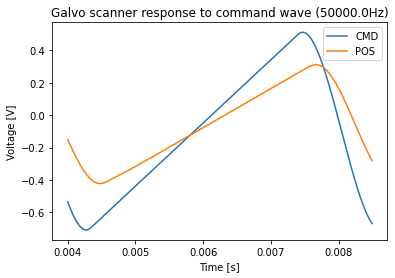

In [18]:
plot_line(t[400:850], cmd[400:850], freq=5e4, ylabel1="CMD", ylabel2="POS", y2=pos[400:850])

In [19]:
# -- Calculations for Time Delay between CMD and POS Waveforms -- 

# Calculate time delay b/w CMD and POS waveform by comparing scan line slopes for one waveform
def calc_time_delay_slope(f, t, cmd, pos, graph=True, average=True):
    # usual span of one linear scan within a waveform
    start_idx = 400 #420
    end_idx = 850 #784
    
    cmd_slope_list = [] # list of slopes for each line in CMD waveform
    pos_slope_list = [] # list of slopes for each line in POS waveform
    slope_ratio_list = [] # ratio between slopes
    time_delay_list = [] # each entry is a list of line delays at every sample for each line
    time_ave_delay_list = [] # average of line delays for each line
    time_range_delay_list = [] # ranges of line delays for each line
    cmd_period_list = [] # cmd values for each line
    adj_pos_period_list = [] # pos values for each line
    
    for i in range(11): # checking every 434 (one x frame) samples out of 5000 
        
        if start_idx <= len(cmd) and end_idx <= len(cmd):
            cmd_period = list(cmd[start_idx:end_idx])
            pos_period = list(pos[start_idx:end_idx])
            time_period = t[start_idx:end_idx]

            # get slope for one period
            cmd_max = np.nanmax(cmd_period)
            pos_max = np.nanmax(pos_period)
            cmd_min = np.nanmin(cmd_period)
            pos_min = np.nanmin(pos_period)

            cmd_max_t = cmd_period.index(float(cmd_max))
            pos_max_t = pos_period.index(float(pos_max))
            cmd_min_t = cmd_period.index(float(cmd_min))
            pos_min_t = pos_period.index(float(pos_min))

            cmd_slope = (cmd_max - cmd_min) / (time_period[cmd_max_t] - time_period[cmd_min_t])
            pos_slope = (pos_max - pos_min) / (time_period[pos_max_t] - time_period[pos_min_t])
            slope_ratio = cmd_slope / pos_slope
            
            # adjust line to according slope
            adj_pos_waveform = []
            for j in pos_period:
                adj_pos_waveform.append(j * slope_ratio)
            
            time_delay = []
            for idx in range(len(adj_pos_waveform)):
                voltage = cmd_period[idx]
                for k in range(100): # look forward to around one full period
                    if k + idx >= len(adj_pos_waveform):
                        break
                    if adj_pos_waveform[k + idx - 1] < voltage and adj_pos_waveform[k + idx] >= voltage:
                        time_delay.append( t[k + idx] - t[idx])
                        break
                    elif adj_pos_waveform[k + idx - 1] > voltage and adj_pos_waveform[k + idx] <= voltage:
                        time_delay.append( t[k + idx] - t[idx])
                        break
                        
            cmd_slope_list.append(cmd_slope)
            pos_slope_list.append(pos_slope)
            slope_ratio_list.append(slope_ratio)
            time_delay_list.append(time_delay)
            time_ave_delay_list.append(np.average(time_delay))
            time_range_delay_list.append(np.max(time_delay) - np.min(time_delay))
            cmd_period_list.append(cmd_period)
            adj_pos_period_list.append(adj_pos_waveform)
            
            start_idx = 434 + start_idx
            end_idx = 434 + end_idx
            
        else:
            break 
    
    # plot slope vs. average time delay 
    if graph == True:
        plot_xy_scatter("Slope vs. Average Time Delay (" + str(f) + " Rate)", "Slope", "Time Delay", 
                        pos_slope_list, time_ave_delay_list)
    
    # return list of slopes for each POS scan line, average time delay for each scan line, 
        # and time delay range for each scan line
    if average == True:
        return pos_slope_list, time_ave_delay_list, time_range_delay_list, np.average(slope_ratio_list)
    
    # or return list of slopes for each CMD and POS scan line, list of slope ratios, and the average of those ratios
    else:
        return cmd_slope_list, pos_slope_list, slope_ratio_list, time_delay_list
    

    
# Calculate average time delay b/w CMD and POS waveforms by scaling POS waveform - using correlation
def calc_time_delay_corr(f, t, cmd, pos, graph=True):
    ps, t_ave_delay, t_range_delay, sr_ave = calc_time_delay_slope(f, t, cmd, pos, False, True)
    adj_pos_waveform = []
    for i in pos:
        adj_pos_waveform.append(i * ave_slope_ratio)
    
    xcorr = np.correlate(pos, cmd, "full")
    dt = np.linspace(-t[-1], t[-1], (2 * len(t)) - 1)
    t_shift = dt[xcorr.argmax()]
    
    if graph == True:
        plot_cmd_pos(f, t, cmd, adj_pos_waveform)
    return t_shift, adj_pos_waveform



# Calculate average time delay b/w CMD and POS waveforms by scaling POS waveform - using averaged slope difference
def calc_time_delay_ave_slope(f, t, cmd, pos):
    ps, t_ave_delay, t_range_delay, sr_ave = calc_time_delay_slope(f, t, cmd, pos, False, True)
    adj_pos_waveform = []
    for i in pos:
        adj_pos_waveform.append(i * sr_ave)
    
    time_delay = []
    for idx in range(len(cmd)):
        voltage = cmd[idx]
        for j in range(100): # look forward to around one full period
            if j + idx >= len(t):
                break
            if adj_pos_waveform[idx - 1] < voltage and adj_pos_waveform[idx] > voltage:
                continue
            if adj_pos_waveform[j + idx - 1] < voltage and adj_pos_waveform[j + idx] >= voltage:
                time_delay.append( t[j + idx] - t[idx])
                break
            elif adj_pos_waveform[j + idx - 1] > voltage and adj_pos_waveform[j + idx] <= voltage:
                time_delay.append( t[j + idx] - t[idx])
                break
    
    new_time_delay = []
    for i in time_delay:
        new_time_delay.append(i * 1000)

    plot_line(t[:len(time_delay)], cmd[:len(time_delay)], title="Galvo Response Compared with Time Delay", 
              xlabel="Time [s]", ylabel="Voltage [V]", ylabel1="CMD", ylabel2="POS", ylabel3="Time Delay (upscaled)", 
              y2=adj_pos_waveform[:len(time_delay)], y3=new_time_delay)
    plot_line(t[:len(time_delay)], time_delay, title="Time vs. Corresponding Time Delay (" + str(f) + "Hz)", 
              xlabel="Time [s]", ylabel="Time Delay [s]")
    
    return t[:len(time_delay)], cmd[:len(time_delay)], adj_pos_waveform[:len(time_delay)], new_time_delay

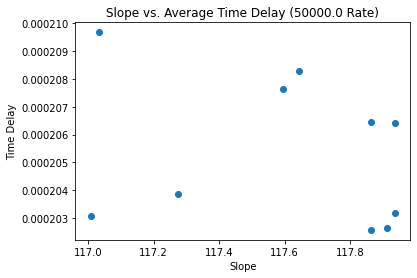

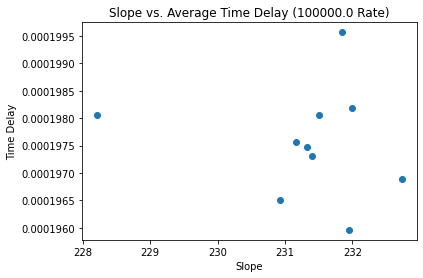

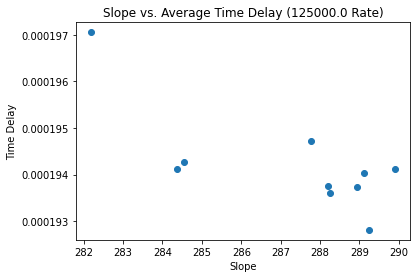

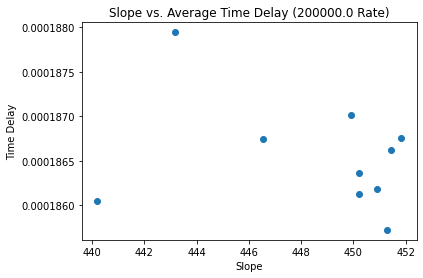

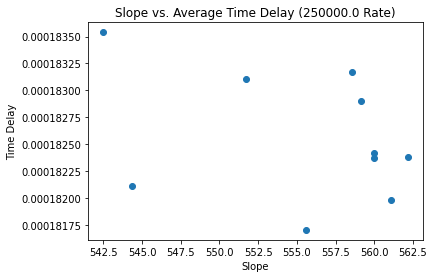

In [20]:
# Scan Line Slopes vs. Average Time Delay for one frame for different sampling rates
# (time delay shown to differentiate along waveform and differentiates based on sampling rate)

pos_slope_5e4, ave_delay_5e4, range_delay_5e4, sr_ave_5e4 = calc_time_delay_slope(5e4, t2, cmd2, pos2, True, True)
pos_slope_1e5, ave_delay_1e5, range_delay_1e5, sr_ave_1e5 = calc_time_delay_slope(1e5, t, cmd, pos, True, True)
pos_slope_1_25e5, ave_delay_1_25e5, range_delay_1_25e5, sr_ave_1_25e5 = calc_time_delay_slope(1.25e5, t3, cmd3, pos3, True, True)
pos_slope_2e5, ave_delay_2e5, range_delay_2e5, sr_ave_2e5 = calc_time_delay_slope(2e5, t4, cmd4, pos4, True, True)
pos_slope_2_5e5, ave_delay_2_5e5, range_delay_2_5e5, sr_ave_2_5e5 = calc_time_delay_slope(2.5e5, t5, cmd5, pos5, True, True)

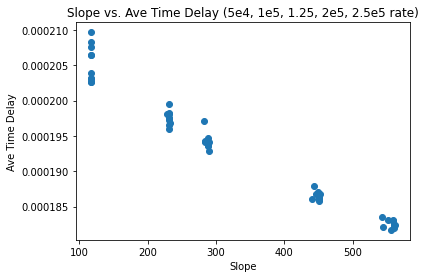

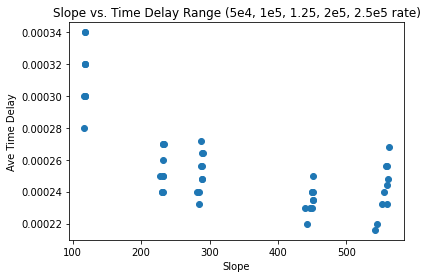

In [21]:
# Scan Line Slopes vs. Average Time Delay for different sampling rates combined
# (each cluster is slopes of scan lines for one sampling rate) 
# (shown to be a downward sloping curve)

combined_time_delay_ave = ave_delay_5e4 + ave_delay_1e5 + ave_delay_1_25e5 + ave_delay_2e5 + ave_delay_2_5e5
combined_pos_slope = pos_slope_5e4 + pos_slope_1e5 + pos_slope_1_25e5 + pos_slope_2e5 + pos_slope_2_5e5
combined_time_delay_range = range_delay_5e4 + range_delay_1e5 + range_delay_1_25e5 + range_delay_2e5 + range_delay_2_5e5

plot_xy_scatter("Slope vs. Ave Time Delay (5e4, 1e5, 1.25, 2e5, 2.5e5 rate)", "Slope", "Ave Time Delay", combined_pos_slope, combined_time_delay_ave)
plot_xy_scatter("Slope vs. Time Delay Range (5e4, 1e5, 1.25, 2e5, 2.5e5 rate)", "Slope", "Ave Time Delay", combined_pos_slope, combined_time_delay_range)

4.842007507284899e-07
1.5996028682352392


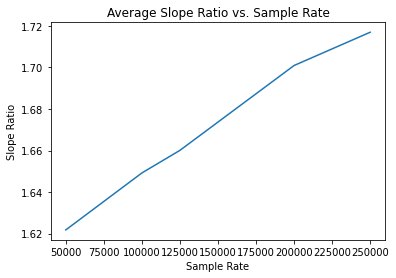

In [22]:
# slope_list = [sr_ave, sr_ave2, sr_ave3, sr_ave4, sr_ave5]
# samp_rate_list = [5e4, 1e5, 1.25e5, 2e5, 2.5e5]
slope_list = [sr_ave_5e4, sr_ave_1e5, sr_ave_1_25e5, sr_ave_2e5, sr_ave_2_5e5]
samp_rate_list = [5e4, 1e5, 1.25e5, 2e5, 2.5e5]
plot_line(samp_rate_list, slope_list, freq=None, title="Average Slope Ratio vs. Sample Rate", xlabel="Sample Rate", ylabel="Slope Ratio")
slope, intercept, r_value, p_value, std_err = stats.linregress(samp_rate_list, slope_list)
print(slope)
print(intercept)

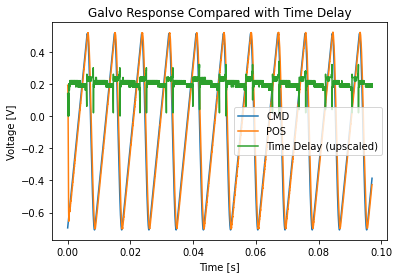

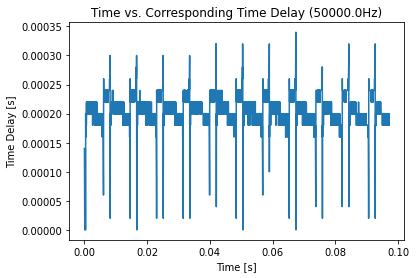

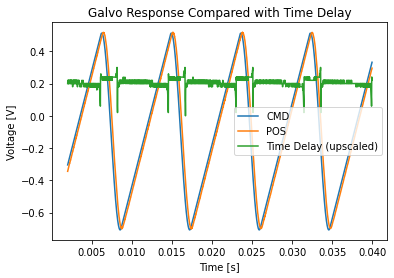

In [23]:
# Plotting time delay with CMD and POS waveform along time
# (time delay seems to decrease along scan line)

new_t, new_cmd, new_adj, time_delay = calc_time_delay_ave_slope(5e4, t2, cmd2, pos2)
plot_line(new_t[100:2000], new_cmd[100:2000], title="Galvo Response Compared with Time Delay", xlabel="Time [s]",
          ylabel="Voltage [V]", ylabel1="CMD", ylabel2="POS", ylabel3="Time Delay (upscaled)", y2=new_adj[100:2000],
          y3=time_delay[100:2000])

In [24]:
# new_t2, new_cmd2, new_adj2, time_delay2 = calc_time_delay_ave_slope(1e5, t, cmd, pos)
# plot_line(new_t2[100:2000], new_cmd2[100:2000], title="Galvo Response Compared with Time Delay", xlabel="Time [s]",
#           ylabel="Voltage [V]", ylabel1="CMD", ylabel2="POS", ylabel3="Time Delay (upscaled)", y2=new_adj2[100:2000],
#           y3=time_delay2[100:2000])

In [25]:
# new_t3, new_cmd3, new_adj3, time_delay3 = calc_time_delay_ave_slope(1.25e5, t3, cmd3, pos3)
# plot_line(new_t3[100:2000], new_cmd3[100:2000], title="Galvo Response Compared with Time Delay", xlabel="Time [s]",
#           ylabel="Voltage [V]", ylabel1="CMD", ylabel2="POS", ylabel3="Time Delay (upscaled)", y2=new_adj3[100:2000],
#           y3=time_delay3[100:2000])

In [26]:
# new_t4, new_cmd4, new_adj4, time_delay4 = calc_time_delay_ave_slope(2e5, t4, cmd4, pos4)
# plot_line(new_t4[100:2000], new_cmd4[100:2000], title="Galvo Response Compared with Time Delay", xlabel="Time [s]",
#           ylabel="Voltage [V]", ylabel1="CMD", ylabel2="POS", ylabel3="Time Delay (upscaled)", y2=new_adj4[100:2000],
#           y3=time_delay4[100:2000])

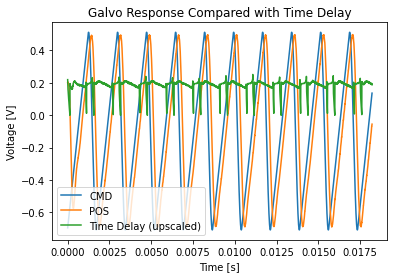

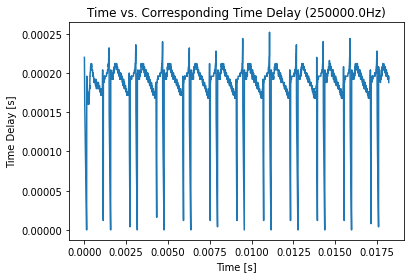

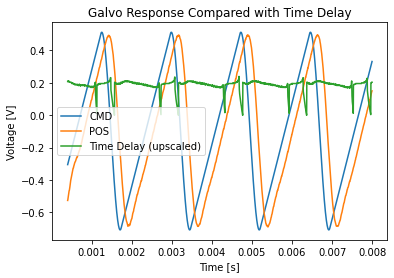

In [27]:
new_t5, new_cmd5, new_adj5, time_delay5 = calc_time_delay_ave_slope(2.5e5, t5, cmd5, pos5)
plot_line(new_t5[100:2000], new_cmd5[100:2000], title="Galvo Response Compared with Time Delay", xlabel="Time [s]",
          ylabel="Voltage [V]", ylabel1="CMD", ylabel2="POS", ylabel3="Time Delay (upscaled)", y2=new_adj5[100:2000],
          y3=time_delay5[100:2000])

In [28]:
# -- Shifting scaled POS waveform to see how closely matches with cmd waveform --

def adj_for_delay(f, t, cmd, pos, graph=True):
    time_shift, adj_pos_waveform = calc_time_delay_ave_slope(f, t, cmd, pos)
    time_idx = 0
    for i in range(len(t)):
        if t[i] >= time_shift:
            time_idx = i
            break
    new_pos_waveform = adj_pos_waveform[time_idx:]
    adj_cmd_waveform = cmd[:(len(cmd) - time_idx)]
    adj_time_waveform = t[:(len(cmd) - time_idx)]
    if graph == True:
        plot_cmd_pos(f, adj_time_waveform, adj_cmd_waveform, new_pos_waveform)
        
# adj_for_delay(1e5, t, cmd, pos, True)
# adj_for_delay(1e5, t[:2000], cmd[:2000], pos[:2000], True)
# adj_for_delay(5e4, t2, cmd2, pos2, True)
# adj_for_delay(5e4, t2[:2000], cmd2[:2000], pos2[:2000], True)


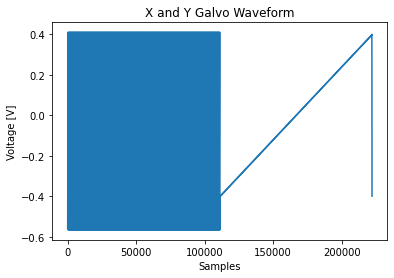

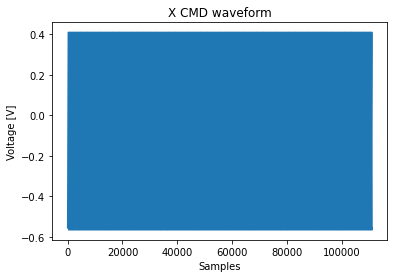

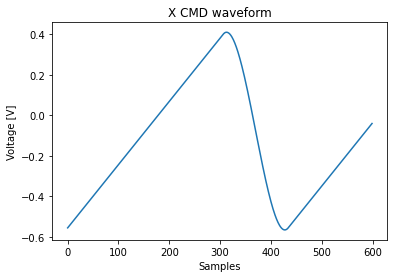

In [29]:
# -- Creating Galvo Waveforms Using Different Zoom Factors (at same sampling rate) --
# (higher zoom = higher amplitude)

zoom = 1.25
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
xFrame= frame[:int(frameLength / 2)]
plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_z1_25 = xFrame[:5000]

In [30]:
# t_z1_25, cmd_z1_25, pos_z1_25 = write_voltage_waveform(1e5, xFrame_waveform_z1_25) # 1.25x zoom
t_z1_25, cmd_z1_25, pos_z1_25 = open_csv("1_25_zoom")

In [31]:
zoom = 1.5
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
xFrame_waveform_z1_5 = xFrame[:5000]

In [32]:
# t_z1_5, cmd_z1_5, pos_z1_5 = write_voltage_waveform(1e5, xFrame_waveform_z1_5) # 1.5x zoom
t_z1_5, cmd_z1_5, pos_z1_5 = open_csv("1_5_zoom")

In [33]:
zoom = 1.75
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
xFrame_waveform_z1_75 = xFrame[:5000]

In [34]:
# t_z1_75, cmd_z1_75, pos_z1_75 = write_voltage_waveform(1e5, xFrame_waveform_z1_75) # 1.75x zoom
t_z1_75, cmd_z1_75, pos_z1_75 = open_csv("1_75_zoom")

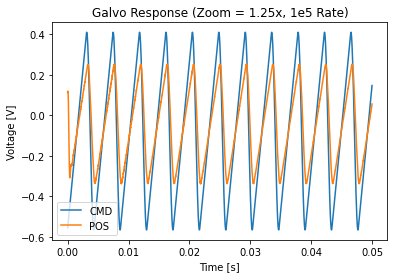

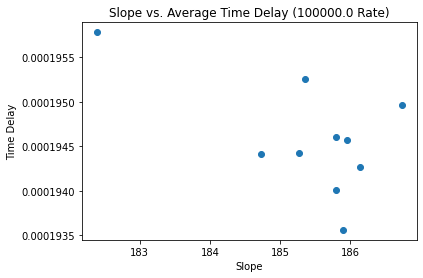

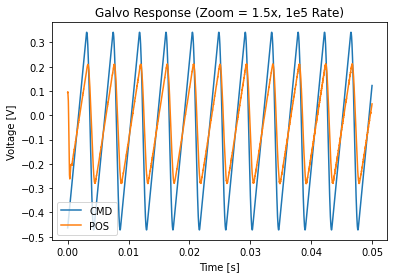

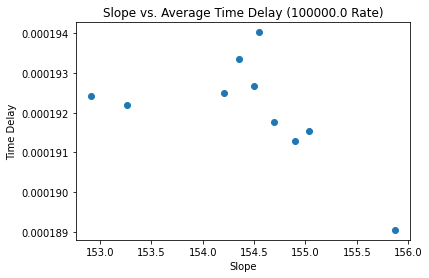

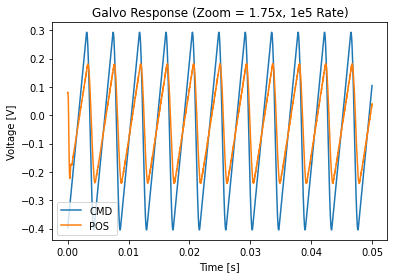

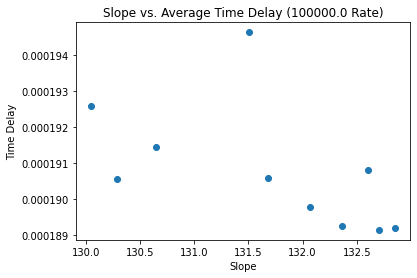

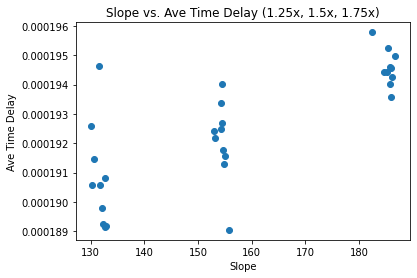

In [35]:
# -- Plotting Different Zoom Factors and Calculating/Comparing Time Delays --
# (time delays differ based on different zoom factors)

plot_line(t_z1_25, cmd_z1_25, title="Galvo Response (Zoom = 1.25x, 1e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_z1_25)
pos_slope_1_25x, ave_delay_1_25x, range_delay_1_25x, sr_ave_1_25x = calc_time_delay_slope(1e5, t_z1_25, cmd_z1_25, pos_z1_25, True, True)

plot_line(t_z1_5, cmd_z1_5, title="Galvo Response (Zoom = 1.5x, 1e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_z1_5)
pos_slope_1_5x, ave_delay_1_5x, range_delay_1_5x, sr_ave_1_5x = calc_time_delay_slope(1e5, t_z1_5, cmd_z1_5, pos_z1_5, True, True)

plot_line(t_z1_75, cmd_z1_75, title="Galvo Response (Zoom = 1.75x, 1e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_z1_75)
pos_slope_1_75x, ave_delay_1_75x, range_delay_1_75x, sr_ave_1_75x = calc_time_delay_slope(1e5, t_z1_75, cmd_z1_75, pos_z1_75, True, True)

combined_time_delay_ave = ave_delay_1_25x + ave_delay_1_5x + ave_delay_1_75x
combined_pos_slope = pos_slope_1_25x + pos_slope_1_5x + pos_slope_1_75x
plot_xy_scatter("Slope vs. Ave Time Delay (1.25x, 1.5x, 1.75x)", "Slope", "Ave Time Delay", combined_pos_slope, combined_time_delay_ave)


In [36]:
# 1.66x = scale factor that scales POS to around CMD waveform

# zoom = 1.66
# frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, zoom, undershoot, 0, 0, 0, 0)
# xFrame = frame[:int(frameLength / 2)]
# xFrame_waveform_z1_66 = xFrame[:5000]

In [37]:
# t_z1_66, cmd_z1_66, pos_z1_66 = write_voltage_waveform(1e5, xFrame_waveform_z1_66)
# plot_line(t_z1_66, cmd_z1_66, title="Galvo Response (Zoom = 1.66x, 1e5 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_z1_66)

In [38]:
# -- Creating Galvo Waveforms Using Different Undershoot Lengths (at same sampling rate) --

frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, 1, 0, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
# plot_galvo("X and Y Galvo Waveform", "Samples", "Voltage [V]", frame)
# plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame)
# plot_galvo("X CMD waveform", "Samples", "Voltage [V]", xFrame[:600])
xFrame_waveform_us_0 = xFrame[:5000]

In [39]:
# t_us_0, cmd_us_0, pos_us_0 = write_voltage_waveform(2.5e5, xFrame_waveform_us_0) # 0 undershoot
# t_us_0, cmd_us_0, pos_us_0 = open_csv("1_25e6rate_0us") # change sampling rate
# plot_line(t_us_0, cmd_us_0, title="Galvo Response (No Undershoot, 1.25e6 Rate)", ylabel1="CMD", ylabel2="POS", y2=pos_us_0)

In [40]:
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, 1, 25, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
xFrame_waveform_us_25 = xFrame[:5000]

In [41]:
# t2_5e5_us25, cmd2_5e5_us25, pos2_5e5_us25 = write_voltage_waveform(2.5e5, xFrame_waveform_us_25) # 25 undershoot

In [42]:
# t2_5e5_us0, cmd2_5e5_us0, pos2_5e5_us0 = write_voltage_waveform(2.5e5, xFrame_waveform_us_0) # 50 undershoot

In [43]:
frame = GenerateGalvoFrame(pixelsPerLine, linesPerFrame, pixelsPerLine, 1, 75, 0, 0, 0, 0)
xFrame = frame[:int(frameLength / 2)]
xFrame_waveform_us_75 = xFrame[:5000]

In [44]:
# t2_5e5_us75, cmd2_5e5_us75, pos2_5e5_us75 = write_voltage_waveform(2.5e5, xFrame_waveform_us_75) # 75 undershoot

In [45]:
# -- Calculate Start and Stop Voltage of a Linear Scan Line --
def new_line_regression(x_data, y_data, start, end, new_start=None, new_end=None, title="Galvo Response"):
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data[start:end], y_data[start:end])
    if new_start == None and new_end == None: # if length is the same
        new_start = start
        new_end = end
    
    old_y_data_section = y_data[start:end]
    new_y_data_section = y_data[new_start:new_end]
    
    # generated linear fit (same length)
    same_linear_fit = []
    for i in x_data[start:end]:
        val = intercept + slope * i
        same_linear_fit.append(val)

    # calculate voltage differences b/w actual and linear fit (same length)
    same_y_diff_list = []
    for i in range(len(same_linear_fit)):
        y_diff = abs(old_y_data_section[i] - same_linear_fit[i])
        same_y_diff_list.append(y_diff)

    # average and max of those differences (of same length)
    y_ave = np.average(same_y_diff_list)
    y_max = np.max(same_y_diff_list)
    
    # generate linear fit (longer length)
    new_linear_fit = []
    for i in x_data[new_start:new_end]:
        val = intercept + slope * i
        new_linear_fit.append(val)
    
    # calculate voltage differences b/w actual and linear fit (longer length)
    new_y_diff_list = []
    for i in range(len(new_linear_fit)):
        new_y_diff = abs(new_y_data_section[i] - new_linear_fit[i])
        new_y_diff_list.append(new_y_diff)
                                
    # finding start and stop voltages
    # upper half of data
    max_idx = 0
    for i in range(int(len(new_y_diff_list)/2)):
        idx = int(len(new_y_diff_list)/2) + i
        if idx > len(x_data): # if index goes over
            break
        else: 
            y_diff = abs(new_y_diff_list[idx])
            if y_diff > y_max: 
                max_idx = idx
                break
    y_stop = new_y_data_section[max_idx]
    
    # lower half of data
    min_idx = 0
    for i in range(int(len(new_y_diff_list)/2)):
        idx = int(len(new_y_diff_list)/2) - i
        y_diff = abs(new_y_diff_list[idx])
        if y_diff > y_max:
            min_idx = idx
            break
    y_start = new_y_data_section[min_idx]
    
    new_x = x_data[new_start:new_end]
    new_y = y_data[new_start:new_end]
    
    print(title + "\nStart Voltage: " + str(y_start) + "\nStop Voltage: " + str(y_stop))    
    plot_line(new_x, new_y, title=title, ylabel1="Actual", ylabel2="Linear Fit", ylabel3="Voltage Difference From Linear Fit", y2=new_linear_fit, y3=new_y_diff_list, markers=[min_idx,max_idx])
        
    return x_data[new_start:new_end], y_data[new_start:new_end], new_linear_fit, y_start, y_stop

In [46]:
# # Line Regression - Rate = 2.5e5, Undershoot = 0

# x1, old_y, new_y, ystart1, yend1 = new_line_regression(t2_5e5_us0, cmd2_5e5_us0, 400, 625, new_start=350, new_end=675, title="Start and Stop on CMD (2.5e5) Undershoot = 0")
# x2, old_y2, new_y2, ystart2, yend2 = new_line_regression(t2_5e5_us0, pos2_5e5_us0, 450, 675, new_start=400, new_end=725, title="Start and Stop on POS (2.5e5) Undershoot = 0")

In [47]:
# # Line Regression - Rate = 2.5e5, Undershoot = 25

# x5, old_y5, new_y5, ystart5, yend5 = new_line_regression(t2_5e5_us25, cmd2_5e5_us25, 425, 675, new_start=375, new_end=725, title="Start and Stop on CMD (2.5e5) Undershoot = 25")
# x6, old_y6, new_y6, ystart6, yend6 = new_line_regression(t2_5e5_us25, pos2_5e5_us25, 475, 725, new_start=425, new_end=775, title="Start and Stop on POS (2.5e5) Undershoot = 25")

In [48]:
# # Line Regression - Rate = 2.5e5, Undershoot = 50

# x3, old_y3, new_y3, ystart3, yend3 = new_line_regression(t5, cmd5, 450, 725, new_start=400, new_end=775, title="Start and Stop on CMD (2.5e5) Undershoot = 50")
# x4, old_y4, new_y4, ystart4, yend4 = new_line_regression(t5, pos5, 500, 775, new_start=450, new_end=825, title="Start and Stop on POS (2.5e5) Undershoot = 50")

In [49]:
# # Line Regression - Rate = 2.5e5, Undershoot = 75

# x7, old_y7, new_y7, ystart7, yend7 = new_line_regression(t2_5e5_us75, cmd2_5e5_us75, 475, 775, new_start=425, new_end=825, title="Start and Stop on CMD (2.5e5) Undershoot = 75")
# x8, old_y8, new_y8, ystart8, yend8 = new_line_regression(t2_5e5_us75, pos2_5e5_us75, 525, 800, new_start=475, new_end=875, title="Start and Stop on POS (2.5e5) Undershoot = 75")

In [441]:
# -- Generating Scan Waveform Based on Specified Start and Stop POS Voltage -- 

# Generate one x scan waveform
def scan_waveform(start_voltage, end_voltage, time_frame, sample_rate):
    # time_frame = .002 # in seconds
    
    rv_slope = -2 * 1000/ (sample_rate)  # 2-5 V/ms converted to V/samples - EDIT
    slope_ratio = 1.4 * (4.842e-7 * sample_rate + 1.6) # to adjust for output waveform
    
    line_delay = .000685 # constant
    
    # waveform parameters
    fw_samps = int(time_frame * sample_rate) # samples in scan line
    fw_slope = ( (end_voltage - start_voltage) * slope_ratio ) / fw_samps # slope of scan line (V/samples)
    
    # Generating Scanner Waveform
    scan_line = []
    retrace = []
    
    scan_start = 0 # start at 0 volts
    time_undershoot = .0005 # 5 ms
    us_samps = sample_rate * time_undershoot # samples in undershoot
    us_start = scan_start - us_samps * fw_slope # voltage where undershoot starts
    
    for i in range(fw_samps):
        val = i * fw_slope + us_start
        scan_line.append(val)
    
    rv_samps = int(-1 * (end_voltage - start_voltage) * slope_ratio / rv_slope) # samples in retrace
    for j in range(rv_samps):
        retrace.append(j * rv_slope + val)
    
    complete_waveform = scan_line + retrace # list of voltages
    num_samples = fw_samps + rv_samps
    samples = []
    for k in range(num_samples):
        samples.append(k)

    print(line_delay)
    return complete_waveform, samples, line_delay

# Generate complete x scan waveform
def x_waveform(waveform, samples, resolution):
    complete_waveform = []
    for i in range(resolution):
        for j in samples:
            complete_waveform.append(waveform[j])
    return complete_waveform

# Generate x scan waveform to write to scanner and plot
def x_scanner_waveform_gen(start_voltage, end_voltage, time_frame, sample_rate, resolution, plot=True):
    single_waveform, num_samples, line_delay= scan_waveform(start_voltage, end_voltage, time_frame, sample_rate)
    gen_waveform = x_waveform(single_waveform, num_samples, resolution)
    
    if plot == True:
        # Plot single scanner waveform
        plot_line(num_samples, single_waveform, title="Scanner Single Waveform (" +str(sample_rate) + " rate, " + 
                  str(start_voltage) + " to " + str(end_voltage)+ "V)", xlabel="Samples")
        # Plot generated waveform, up to 5000 samples
        plot_galvo("Generated Scanner Waveform (5000 samples)", "Samples", "Voltage [V]", gen_waveform[:5000])
    
    return gen_waveform[:5000] # return up to 5000 samples

In [442]:
def plot_start_stop(t, cmd, pos, samp_rate, stop_voltage, start, end, new_start, new_end):
    plot_line(t, cmd, title="Galvo Response (" + str(samp_rate) + " samp rate for "+ str(stop_voltage) + "V)",
          ylabel1="CMD", ylabel2="POS", y2=pos)
    
    x, old_y, new_y, ystart, yend = new_line_regression(
        t, pos, start, end, new_start=new_start, new_end=new_end, 
        title="Start and Stop on POS (" + str(samp_rate) +")")
    
    return x, old_y, new_y, ystart, yend

def percent_error(expected_voltage, actual_values, graph=True, x_label=None, x_data=None):
    error = []
    diff = []
    for val in actual_values:
        error.append(abs((val - expected_voltage)/expected_voltage) * 100)
        diff.append(val - expected_voltage)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, actual_values)
    same_linear_fit = []
    for i in x_data:
        val = intercept + slope * i
        same_linear_fit.append(val)
        
    diff_slope, diff_intercept, r_value, p_value, std_err = stats.linregress(x_data, diff)
    diff_linear_fit = []
    for i in x_data:
        val = diff_intercept + diff_slope * i
        diff_linear_fit.append(val)
    
    adjusted_vals = []
    for i in range(len(x_data)):
        val = actual_values[i] - diff[i]
        adjusted_vals.append(val)
    
    if graph and x_data is not None:
        # print("Slope: " + str(slope) + ", Intercept: " + str(intercept))
        plot_line(x_data, actual_values, title=x_label + " vs. POS Stop Voltage (Expected Voltage " + str(expected_voltage) + "V)",
                  xlabel=x_label, ylabel="Stop Voltage [V]", ylabel1="Actual Voltages", ylabel2="Linear Fit", y2=same_linear_fit)
        
        print("Voltage Difference Slope: " + str(diff_slope) + ", Intercept: " + str(diff_intercept))
        plot_line(x_data, diff, title=x_label + " vs. Difference from Expected Voltage " + str(expected_voltage) + "V",
                  xlabel=x_label, ylabel="Difference", ylabel1="Actual Difference", ylabel2="Linear Fit", y2=diff_linear_fit)
        
        plot_line(x_data, adjusted_vals, title=x_label + " vs. Adjusted POS Stop Voltage " + str(expected_voltage) + "V",
                  xlabel=x_label, ylabel="Stop Voltage [V]")
        
        plot_line(x_data, error, title=x_label + " vs. Percent Error of Expected Voltage " + str(expected_voltage) + "V",
                  xlabel=x_label, ylabel="Percent Error [%]")
        
    return error

def percent_error2(expected_voltage, actual_values, graph=True, x_label=None, x_data=None):
    error = []
    diff = []
    for i in range(len(actual_values)):
        error.append(abs((actual_values[i] - expected_voltage[i])/expected_voltage[i]) * 100)
        diff.append(actual_values[i] - expected_voltage[i])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, actual_values)
    same_linear_fit = []
    for i in x_data:
        val = intercept + slope * i
        same_linear_fit.append(val)
    
    diff_slope, diff_intercept, r_value, p_value, std_err = stats.linregress(x_data, diff)
    diff_linear_fit = []
    for i in x_data:
        val = diff_intercept + diff_slope * i
        diff_linear_fit.append(val)
    
    if graph and x_data is not None:
        # print("Slope: " + str(slope) + ", Intercept: " + str(intercept))
        plot_line(x_data, actual_values, title=x_label + " vs. POS Stop Voltage (Expected Voltage " + str(expected_voltage) + "V)",
                  xlabel=x_label, ylabel="Stop Voltage [V]", ylabel1="Actual Voltages", ylabel2="Linear Fit", y2=same_linear_fit)
        
        plot_line(x_data, diff, title=x_label + " vs. Difference from Expected Voltage " + str(expected_voltage) + "V",
                  xlabel=x_label, ylabel="Difference", ylabel1="Actual Difference", ylabel2="Linear Fit", y2=diff_linear_fit)
        
        plot_line(x_data, error, title=x_label + " vs. Percent Error of Expected Voltage " + str(expected_voltage) + "V",
                  xlabel=x_label, ylabel="Percent Error [%]")
        
    return error

In [443]:
# waveform_1_25e6_1 = x_scanner_waveform_gen(0, 0.5, .002, 1.25e6, 256, False) # 0 - 0.5V at 1.25e6 rate

0.000685
Start and Stop on POS (250000.0)
Start Voltage: -0.03677753198246761
Stop Voltage: 0.5257943434187998


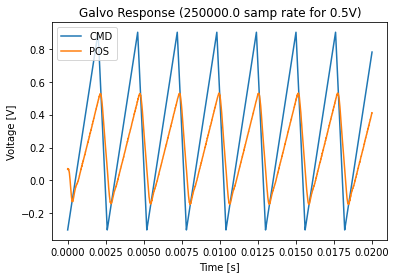

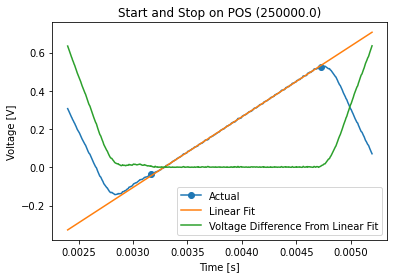

In [444]:
# 0 - 0.5V at 2.5e5 rate

waveform_2_5e5_05 = x_scanner_waveform_gen(0, 0.5, .002, 2.5e5, 256, False)
# t_2_5e5_05, cmd_2_5e5_05, pos_2_5e5_05 = write_voltage_waveform(2.5e5, waveform_2_5e5_05)
t_2_5e5_05, cmd_2_5e5_05, pos_2_5e5_05 = open_csv("0-0_5at2_5e5")

x_2_5e5_05, old_y_2_5e5_05, new_y_2_5e5_05, ystart_2_5e5_05, yend_2_5e5_05 = plot_start_stop(
    t_2_5e5_05, cmd_2_5e5_05, pos_2_5e5_05, 2.5e5, 0.5, 800, 1150, 600, 1300)

0.000685
Start and Stop on POS (200000.0)
Start Voltage: -0.14007194281417043
Stop Voltage: 0.51891846276853


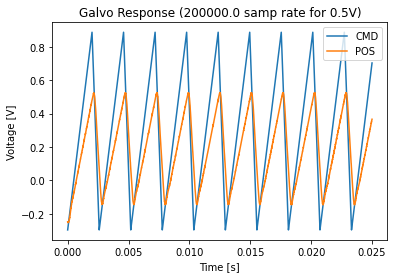

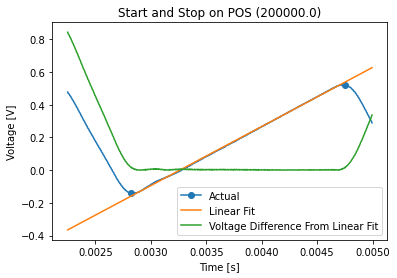

In [445]:
# 0 - 0.5V at 2e5 rate

waveform_2e5_05 = x_scanner_waveform_gen(0, 0.5, .002, 2e5, 256, False) 
# t_2e5_05, cmd_2e5_05, pos_2e5_05 = write_voltage_waveform(2e5, waveform_2e5_05)
t_2e5_05, cmd_2e5_05, pos_2e5_05 = open_csv("0-0_5at2e5")

x_2e5_05, old_y_2e5_05, new_y_2e5_05, ystart_2e5_05, yend_2e5_05 = plot_start_stop(
    t_2e5_05, cmd_2e5_05, pos_2e5_05, 2e5, 0.5, 800, 950, 450, 1000)

0.000685
Start and Stop on POS (125000.0)
Start Voltage: -0.0575614309196016
Stop Voltage: 0.5106361520609428


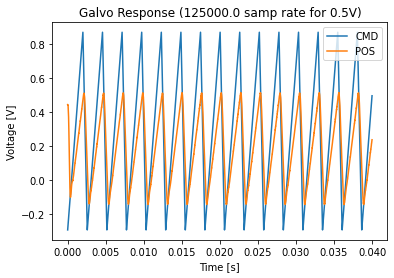

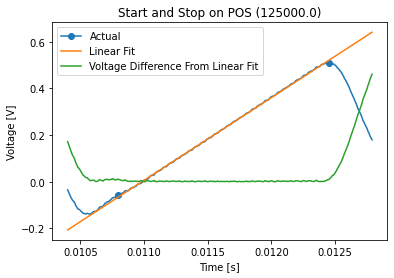

In [446]:
# 0 - 0.5V at 1.25e5 rate

waveform_1_25e5_05 = x_scanner_waveform_gen(0, 0.5, .002, 1.25e5, 256, False)
# t_1_25e5_05, cmd_1_25e5_05, pos_1_25e5_05 = write_voltage_waveform(1.25e5, waveform_1_25e5_05)
t_1_25e5_05, cmd_1_25e5_05, pos_1_25e5_05 = open_csv("0-0_5at1_25e5")

x_1_25e5_05, old_y_1_25e5_05, new_y_1_25e5_05, ystart_1_25e5_05, yend_1_25e5_05 = plot_start_stop(
    t_1_25e5_05, cmd_1_25e5_05, pos_1_25e5_05, 1.25e5, 0.5, 1350, 1500, 1300, 1600)

0.000685
Start and Stop on POS (100000.0)
Start Voltage: -0.056155001681746794
Stop Voltage: 0.5062605917204479


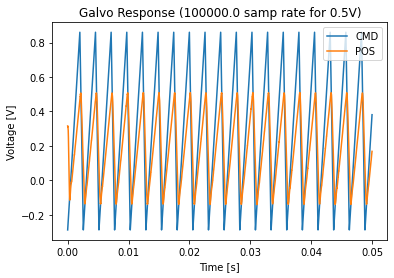

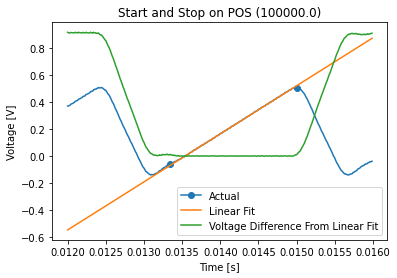

In [447]:
# 0 - 0.5V at 1e5 rate

waveform_1e5_05 = x_scanner_waveform_gen(0, 0.5, .002, 1e5, 256, False)
# t_1e5_05, cmd_1e5_05, pos_1e5_05 = write_voltage_waveform(1e5, waveform_1e5_05)
t_1e5_05, cmd_1e5_05, pos_1e5_05 = open_csv("0-0_5at1e5")

x_1e5_05, old_1e5_05, new_y_1e5_05, ystart_1e5_05, yend_1e5_05 = plot_start_stop(
    t_1e5_05, cmd_1e5_05, pos_1e5_05, 1e5, 0.5, 1350, 1500, 1200, 1600)

0.000685
Start and Stop on POS (50000.0)
Start Voltage: -0.02318204898606735
Stop Voltage: 0.4911024007185213


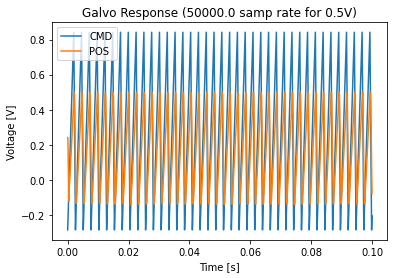

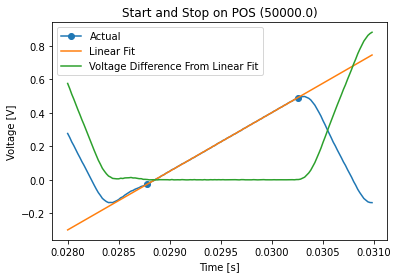

In [448]:
# 0 - 0.5V at 5e4 rate

waveform_5e4_05 = x_scanner_waveform_gen(0, 0.5, .002, 5e4, 256, False) 
# t_5e4_05, cmd_5e4_05, pos_5e4_05 = write_voltage_waveform(5e4, waveform_5e4_05)
t_5e4_05, cmd_5e4_05, pos_5e4_05 = open_csv("0-0_5at5e4")

x_5e4_05, old_5e4_05, new_y_5e4_05, ystart_5e4_05, yend_5e4_05 = plot_start_stop(
    t_5e4_05, cmd_5e4_05, pos_5e4_05, 5e4, 0.5, 1450, 1500, 1400, 1550)

0.000685
Start and Stop on POS (250000.0)
Start Voltage: -0.04130935960689745
Stop Voltage: 0.7828585597897635


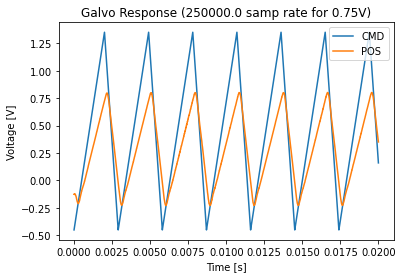

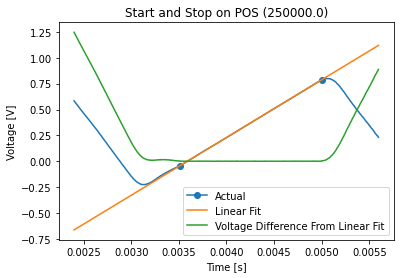

In [449]:
# 0 - 0.75V at 2.5e5 rate

waveform_2_5e5_075 = x_scanner_waveform_gen(0, 0.75, .002, 2.5e5, 256, False)
# t_2_5e5_075, cmd_2_5e5_075, pos_2_5e5_075 = write_voltage_waveform(2.5e5, waveform_2_5e5_075)
t_2_5e5_075, cmd_2_5e5_075, pos_2_5e5_075 = open_csv("0-0_75at2_5e5")

x_2_5e5_075, old_y_2_5e5_075, new_y_2_5e5_075, ystart_2_5e5_075, yend_2_5e5_075 = plot_start_stop(
    t_2_5e5_075, cmd_2_5e5_075, pos_2_5e5_075, 2.5e5, 0.75, 900, 1200, 600, 1400)

0.000685
Start and Stop on POS (200000.0)
Start Voltage: -0.05443603261059626
Stop Voltage: 0.779733158477917


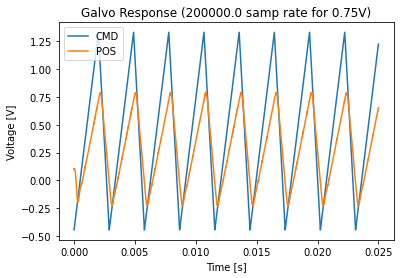

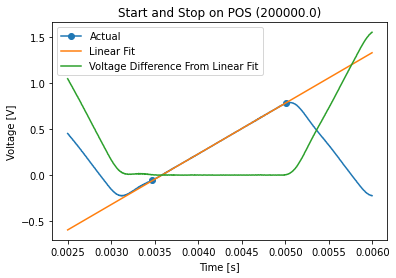

In [450]:
# 0 - 0.75V at 2e5 rate

waveform_2e5_075 = x_scanner_waveform_gen(0, 0.75, .002, 2e5, 256, False)
# t_2e5_075, cmd_2e5_075, pos_2e5_075 = write_voltage_waveform(2e5, waveform_2e5_075)
t_2e5_075, cmd_2e5_075, pos_2e5_075 = open_csv("0-0_75at2e5")

x_2e5_075, old_y_2e5_075, new_y_2e5_075, ystart_2e5_075, yend_2e5_075 = plot_start_stop(
    t_2e5_075, cmd_2e5_075, pos_2e5_075, 2e5, 0.75, 750, 1000, 500, 1200)

0.000685
Start and Stop on POS (125000.0)
Start Voltage: -0.08209580731023061
Stop Voltage: 0.7681691737347194


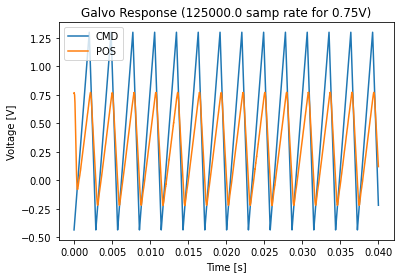

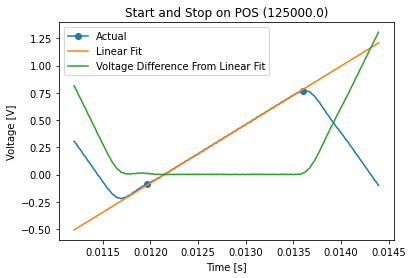

In [451]:
# 0 - 0.75V at 1.25e5 rate

waveform_1_25e5_075 = x_scanner_waveform_gen(0, 0.75, .002, 1.25e5, 256, False)
# t_1_25e5_075, cmd_1_25e5_075, pos_1_25e5_075 = write_voltage_waveform(1.25e5, waveform_1_25e5_075)
t_1_25e5_075, cmd_1_25e5_075, pos_1_25e5_075 = open_csv("0-0_75at1_25e5")

x_1_25e5_075, old_y_1_25e5_075, new_y_1_25e5_075, ystart_1_25e5_075, yend_1_25e5_075 = plot_start_stop(
    t_1_25e5_075, cmd_1_25e5_075, pos_1_25e5_075, 1.25e5, 0.75, 1550, 1700, 1400, 1800)

Line Delay: 0.0006875
Start and Stop on POS (100000.0)
Start Voltage: -0.05349841311600691
Stop Voltage: 0.7480103358812823


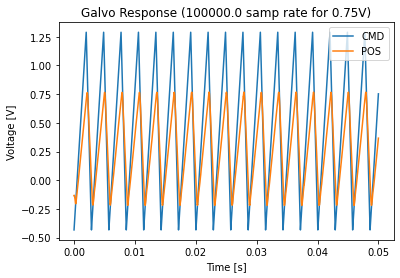

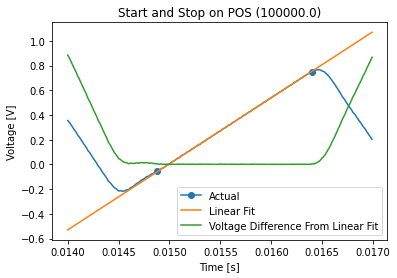

In [288]:
# 0 - 0.75V at 1e5 rate

waveform_1e5_075 = x_scanner_waveform_gen(0, 0.75, .002, 1e5, 256, False) # 0 - 0.5V at 1e5 rate
# t_1e5_075, cmd_1e5_075, pos_1e5_075 = write_voltage_waveform(1e5, waveform_1e5_075)
t_1e5_075, cmd_1e5_075, pos_1e5_075 = open_csv("0-0_75at1e5")

x_1e5_075, old_1e5_075, new_y_1e5_075, ystart_1e5_075, yend_1e5_075 = plot_start_stop(
    t_1e5_075, cmd_1e5_075, pos_1e5_075, 1e5, 0.75, 1500, 1600, 1400, 1700)

Line Delay: 0.0003425
Start and Stop on POS (50000.0)
Start Voltage: 0.07948729417754925
Stop Voltage: 0.7434785041881606


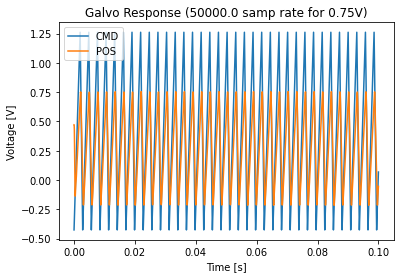

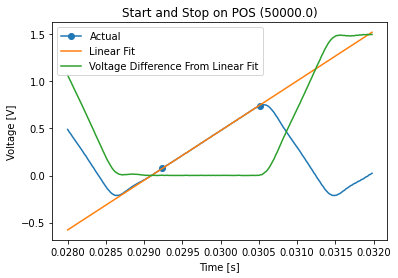

In [289]:
# 0 - 0.75V at 5e4 rate

waveform_5e4_075 = x_scanner_waveform_gen(0, 0.75, .002, 5e4, 256, False)
# t_5e4_075, cmd_5e4_075, pos_5e4_075 = write_voltage_waveform(5e4, waveform_5e4_075)
t_5e4_075, cmd_5e4_075, pos_5e4_075 = open_csv("0-0_75at5e4")

x_5e4_075, old_5e4_075, new_y_5e4_075, ystart_5e4_075, yend_5e4_075 = plot_start_stop(
    t_5e4_075, cmd_5e4_075, pos_5e4_075, 5e4, 0.75, 1470, 1525, 1400, 1600)

Line Delay: 0.0017225
Start and Stop on POS (250000.0)
Start Voltage: -0.0666250859610628
Stop Voltage: 1.04758009831945


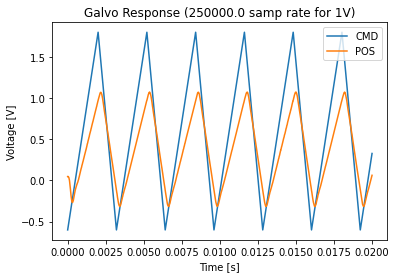

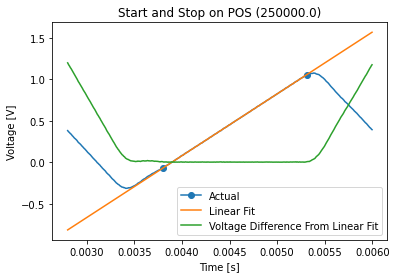

In [291]:
# 0 - 1V at 2.5e5 rate

waveform_2_5e5_1 = x_scanner_waveform_gen(0, 1, .002, 2.5e5, 256, False)
# t_2_5e5_1, cmd_2_5e5_1, pos_2_5e5_1 = write_voltage_waveform(2.5e5, waveform_2_5e5_1)
t_2_5e5_1, cmd_2_5e5_1, pos_2_5e5_1 = open_csv("0-1at2_5e5")

x_2_5e5_1, old_y_2_5e5_1, new_y_2_5e5_1, ystart_2_5e5_1, yend_2_5e5_1 = plot_start_stop(
    t_2_5e5_1, cmd_2_5e5_1, pos_2_5e5_1, 2.5e5, 1, 1000, 1300, 700, 1500)

Line Delay: 0.0013775
Start and Stop on POS (200000.0)
Start Voltage: -0.08787779401674443
Stop Voltage: 1.04648620746672


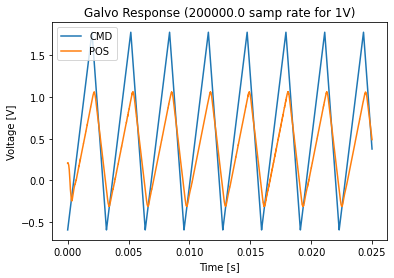

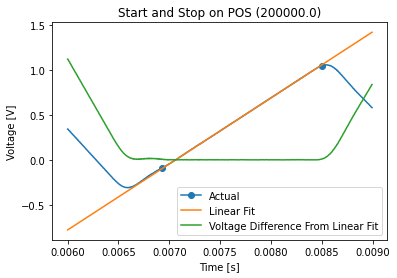

In [292]:
# 0 - 1V at 2e5 rate

waveform_2e5_1 = x_scanner_waveform_gen(0, 1, .002, 2e5, 256, False)
# t_2e5_1, cmd_2e5_1, pos_2e5_1 = write_voltage_waveform(2e5, waveform_2e5_1)
t_2e5_1, cmd_2e5_1, pos_2e5_1 = open_csv("0-1at2e5")

x_2e5_1, old_y_2e5_1, new_y_2e5_1, ystart_2e5_1, yend_2e5_1 = plot_start_stop(
    t_2e5_1, cmd_2e5_1, pos_2e5_1, 2e5, 1, 1400, 1700, 1200, 1800)

Line Delay: 0.00086
Start and Stop on POS (125000.0)
Start Voltage: -0.06287460802271953
Stop Voltage: 1.0142945631219558


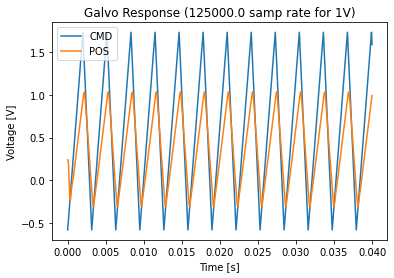

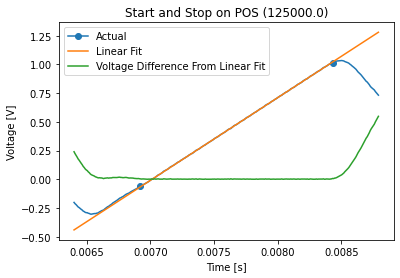

In [293]:
# 0 - 1V at 1.25e5 rate

waveform_1_25e5_1 = x_scanner_waveform_gen(0, 1, .002, 1.25e5, 256, False)
# t_1_25e5_1, cmd_1_25e5_1, pos_1_25e5_1 = write_voltage_waveform(1.25e5, waveform_1_25e5_1)
t_1_25e5_1, cmd_1_25e5_1, pos_1_25e5_1 = open_csv("0-1at1_25e5")

x_1_25e5_1, old_y_1_25e5_1, new_y_1_25e5_1, ystart_1_25e5_1, yend_1_25e5_1 = plot_start_stop(
    t_1_25e5_1, cmd_1_25e5_1, pos_1_25e5_1, 1.25e5, 1, 900, 1050, 800, 1100)

Line Delay: 0.0006875
Start and Stop on POS (100000.0)
Start Voltage: -0.10037938678392373
Stop Voltage: 1.0142945631219558


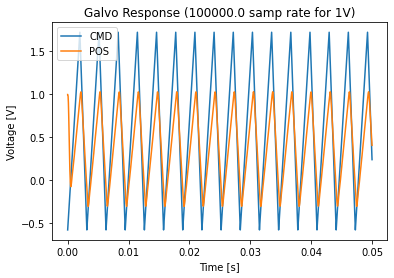

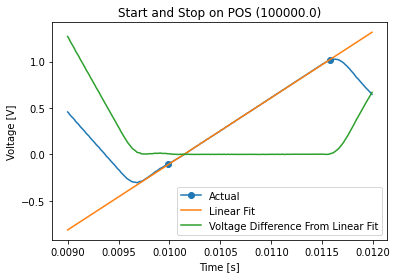

In [294]:
# 0 - 1V at 1e5 rate

waveform_1e5_1 = x_scanner_waveform_gen(0, 1, .002, 1e5, 256, False)
# t_1e5_1, cmd_1e5_1, pos_1e5_1 = write_voltage_waveform(1e5, waveform_1e5_1)
t_1e5_1, cmd_1e5_1, pos_1e5_1 = open_csv("0-1at1e5")

x_1e5_1, old_y_1e5_1, new_y_1e5_1, ystart_1e5_1, yend_1e5_1 = plot_start_stop(
    t_1e5_1, cmd_1e5_1, pos_1e5_1, 1e5, 1, 1000, 1100, 900, 1200)

Line Delay: 0.0003425
Start and Stop on POS (50000.0)
Start Voltage: -0.052091983872488104
Stop Voltage: 0.9814778397886434


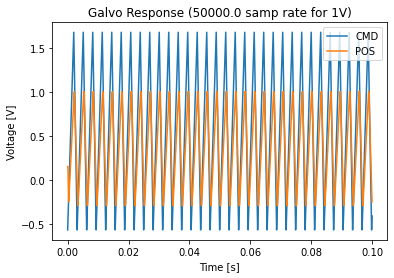

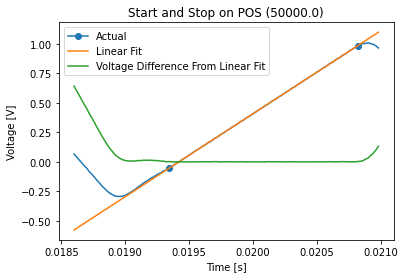

In [295]:
# 0 - 1V at 5e4 rate

waveform_5e4_1 = x_scanner_waveform_gen(0, 1, .002, 5e4, 256, False) # 0 - 0.5V at 1e5 rate
# t_5e4_1, cmd_5e4_1, pos_5e4_1 = write_voltage_waveform(5e4, waveform_5e4_1)
t_5e4_1, cmd_5e4_1, pos_5e4_1 = open_csv("0-1at5e4")

# plot_line(t_5e4_1, cmd_5e4_1, freq=2.5e5, title="Galvo Response (2.5e5 for 0.5V)", ylabel1="CMD", ylabel2="POS", y2=pos_5e4_1)
x_5e4_1, old_y_5e4_1, new_y_5e4_1, ystart_5e4_1, yend_5e4_1 = plot_start_stop(
    t_5e4_1, cmd_5e4_1, pos_5e4_1, 5e4, 1, 970, 1040, 930, 1050)

[1.7795198562957415, 0.8695327749119149, 1.8522160211356553]

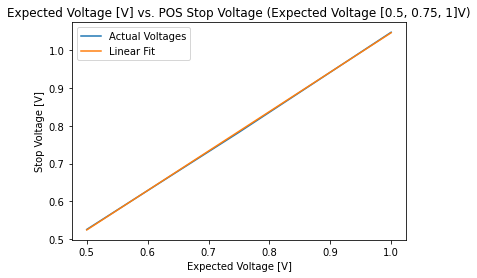

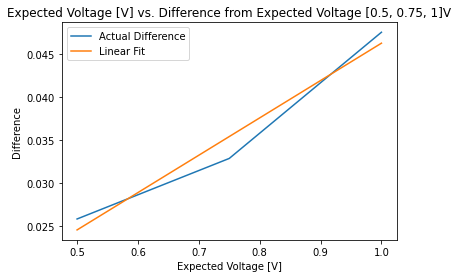

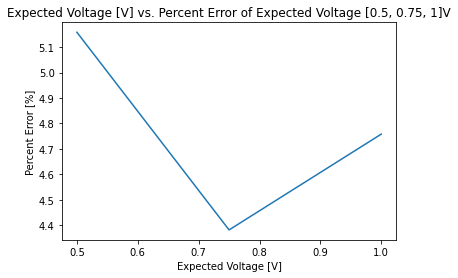

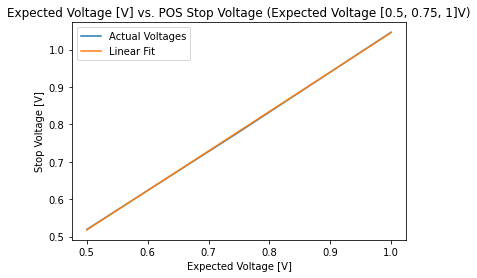

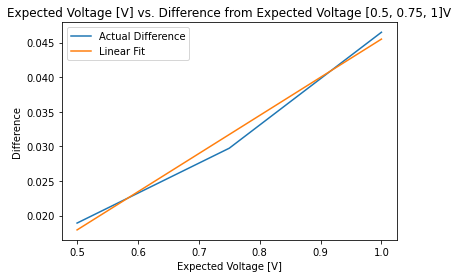

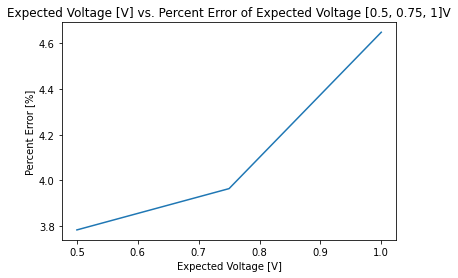

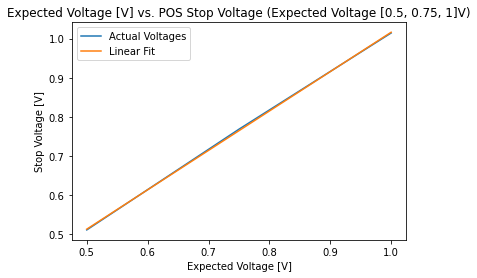

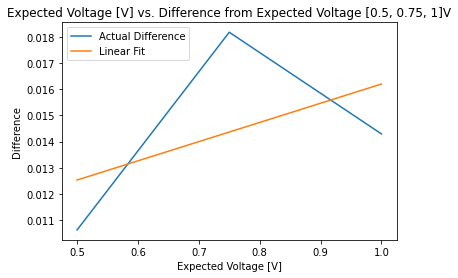

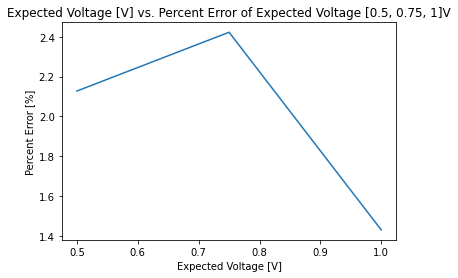

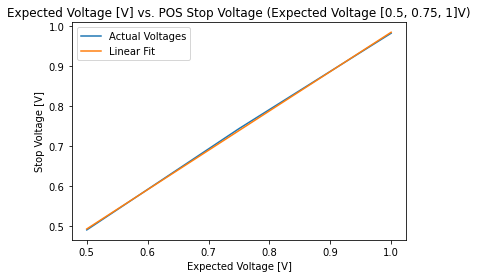

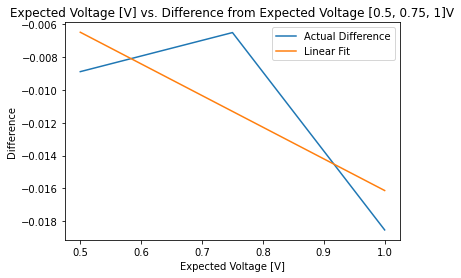

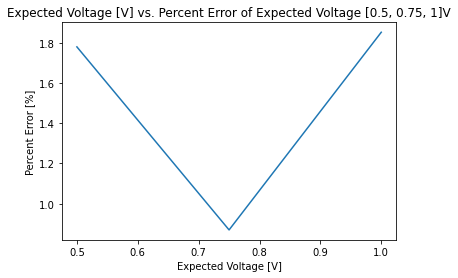

In [421]:
expected_voltage = [0.5, 0.75, 1]
actual_values = [yend_2_5e5_05, yend_2_5e5_075, yend_2_5e5_1]
percent_error2(expected_voltage, actual_values, graph=True, x_label="Expected Voltage [V]", x_data=expected_voltage)

actual_values = [yend_2e5_05, yend_2e5_075, yend_2e5_1]
percent_error2(expected_voltage, actual_values, graph=True, x_label="Expected Voltage [V]", x_data=expected_voltage)

actual_values = [yend_1_25e5_05, yend_1_25e5_075, yend_1_25e5_1]
percent_error2(expected_voltage, actual_values, graph=True, x_label="Expected Voltage [V]", x_data=expected_voltage)

actual_values = [yend_5e4_05, yend_5e4_075, yend_5e4_1]
percent_error2(expected_voltage, actual_values, graph=True, x_label="Expected Voltage [V]", x_data=expected_voltage)


Voltage Difference Slope: 1.6077426566057256e-07, Intercept: -0.012769878383334645


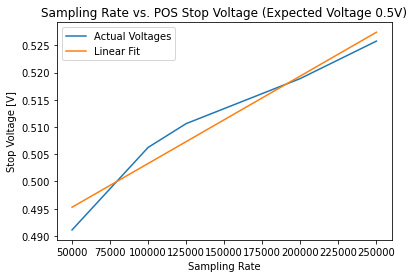

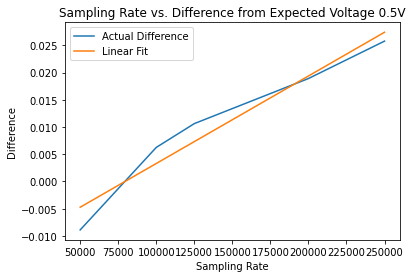

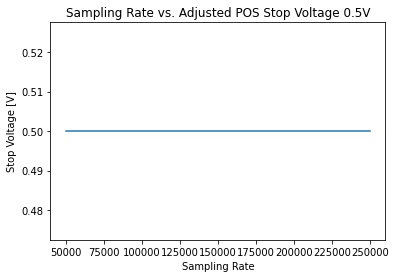

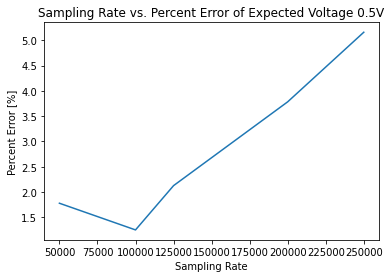

In [410]:
stop_voltages = [yend_5e4_05, yend_1e5_05, yend_1_25e5_05, yend_2e5_05, yend_2_5e5_05]
sampling_rates = [5e4, 1e5, 1.25e5, 2e5, 2.5e5]

error = percent_error(0.5, stop_voltages, graph=True, x_label="Sampling Rate", x_data=sampling_rates)

Voltage Difference Slope: 2.129869022346373e-07, Intercept: -0.016433154409653844


[0.8695327749119149,
 0.26528854916236055,
 2.422556497962584,
 3.9644211303889363,
 4.381141305301798]

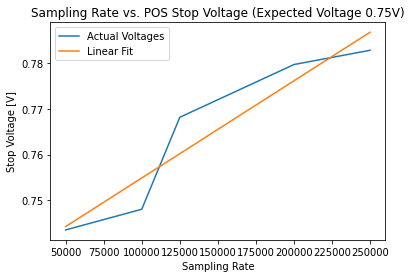

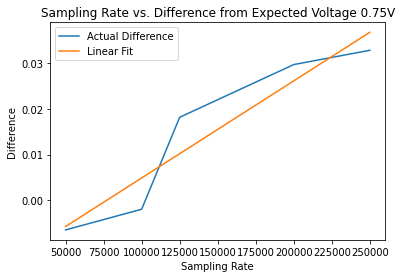

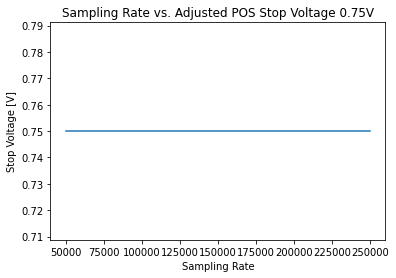

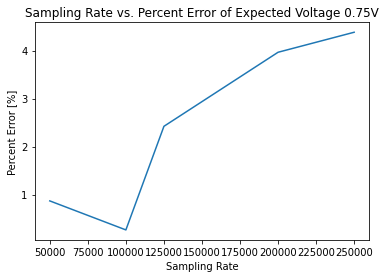

In [411]:
stop_voltages = [yend_5e4_075, yend_1e5_075, yend_1_25e5_075, yend_2e5_075, yend_2_5e5_075]
sampling_rates = [5e4, 1e5, 1.25e5, 2e5, 2.5e5]
percent_error(0.75, stop_voltages, graph=True, x_label="Sampling Rate", x_data=sampling_rates)

Voltage Difference Slope: 3.28749425543671e-07, Intercept: -0.026842012340087273


[1.8522160211356553,
 1.4294563121955761,
 1.4294563121955761,
 4.648620746672005,
 4.758009831945009]

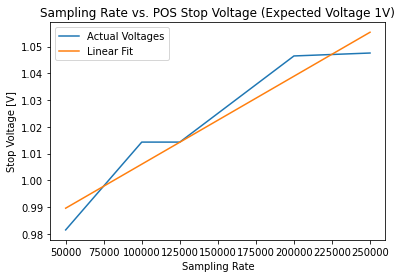

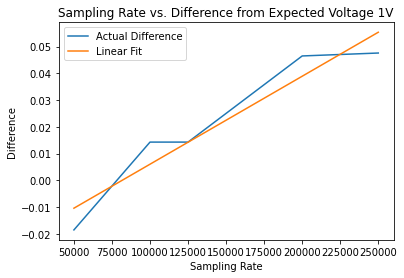

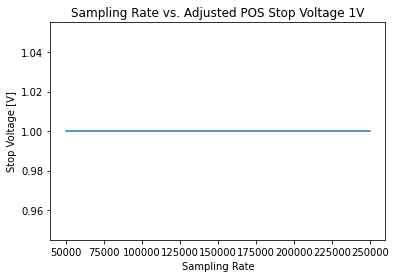

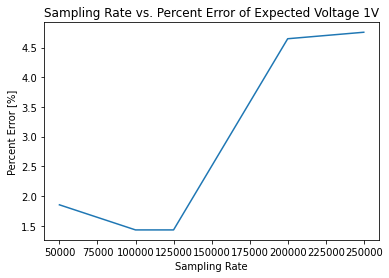

In [412]:
stop_voltages = [yend_5e4_1, yend_1e5_1, yend_1_25e5_1, yend_2e5_1, yend_2_5e5_1]
sampling_rates = [5e4, 1e5, 1.25e5, 2e5, 2.5e5]

percent_error(1, stop_voltages, graph=True, x_label="Sampling Rate", x_data=sampling_rates)

In [298]:
def line_delay_calc(t, cmd, pos):
    next_pos = 0
    curr_pos = 0
    time_pos_0 = []
    time_cmd_start = []
    time_cmd_start.append(t[0])
    for i in range(len(cmd)):
        
        curr_pos = pos[i]
        curr_cmd = cmd[i]
            
        if i-1 > 0:
            prev_cmd = cmd[i - 1]
        else:
            prev_cmd = cmd[i]
        
        if i+1 < len(cmd):
            next_pos = pos[i + 1]
            next_cmd = cmd[i + 1]
        else:
            next_pos = pos[i]
            next_cmd = cmd[i]

        # want to get 0 when sloping up
        if curr_pos <= 0 and next_pos >= 0:
            time_pos_0.append(t[i])
            
        # want to get when cmd minimum
        if prev_cmd > curr_cmd and curr_cmd < next_cmd:
            time_cmd_start.append(t[i])
    
    time_delay_list = []
    if len(time_pos_0) > len(time_cmd_start):
        time_pos_0.pop(0)

    if len(time_pos_0) < len(time_cmd_start):
        time_cmd_start.pop()
        
    for j in range(len(time_cmd_start)):
        time_delay_list.append(round(time_pos_0[j] - time_cmd_start[j], 5))
            
    return time_delay_list


In [422]:
# 2.5e5

t_delay_2_5e5_1 = line_delay_calc(t_2_5e5_1, cmd_2_5e5_1, pos_2_5e5_1)
t_delay_2_5e5_075 = line_delay_calc(t_2_5e5_075, cmd_2_5e5_075, pos_2_5e5_075)
t_delay_2_5e5_05 = line_delay_calc(t_2_5e5_05, cmd_2_5e5_05, pos_2_5e5_05)
print(t_delay_2_5e5_05)

[0.00329, 0.00328, 0.00329, 0.00328, 0.00329, 0.00329, 0.00328, 0.00069]


In [423]:
# 2e5

t_delay_2e5_1 = line_delay_calc(t_2e5_1, cmd_2e5_1, pos_2e5_1)
t_delay_2e5_075 = line_delay_calc(t_2e5_075, cmd_2e5_075, pos_2e5_075)
t_delay_2e5_05 = line_delay_calc(t_2e5_05, cmd_2e5_05, pos_2e5_05)
print(t_delay_2e5_05)

[0.00327, 0.00327, 0.00328, 0.00328, 0.00327, 0.00327, 0.00069, 0.00069, 0.00068, 0.00069]


In [424]:
# 1.25e5

t_delay_1_25e5_1 = line_delay_calc(t_1_25e5_1, cmd_1_25e5_1, pos_1_25e5_1)
t_delay_1_25e5_075 = line_delay_calc(t_1_25e5_075, cmd_1_25e5_075, pos_1_25e5_075)
t_delay_1_25e5_05 = line_delay_calc(t_1_25e5_05, cmd_1_25e5_05, pos_1_25e5_05)
print(t_delay_1_25e5_05)

[0.00066, 0.00069, 0.00068, 0.00069, 0.00068, 0.00068, 0.00068, 0.00069, 0.00068, 0.00067, 0.00068, 0.00068, 0.00068, 0.00069, 0.00068, 0.00068]


In [425]:
# 1e5

t_delay_1e5_1 = line_delay_calc(t_1e5_1, cmd_1e5_1, pos_1e5_1)
t_delay_1e5_075 = line_delay_calc(t_1e5_075, cmd_1e5_075, pos_1e5_075)
t_delay_1e5_05 = line_delay_calc(t_1e5_05, cmd_1e5_05, pos_1e5_05)
print(t_delay_1e5_05)

[0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00069, 0.00068, 0.00069, 0.00068, 0.00068, 0.00069, 0.00068, 0.00068, 0.00068, 0.00068]


In [426]:
# 5e4

t_delay_5e4_1 = line_delay_calc(t_5e4_1, cmd_5e4_1, pos_5e4_1)
t_delay_5e4_075 = line_delay_calc(t_5e4_075, cmd_5e4_075, pos_5e4_075)
t_delay_5e4_05 = line_delay_calc(t_5e4_05, cmd_5e4_05, pos_5e4_05)
print(t_delay_5e4_05)

[0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.0007, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068, 0.00068]


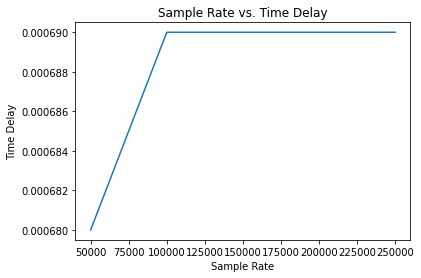

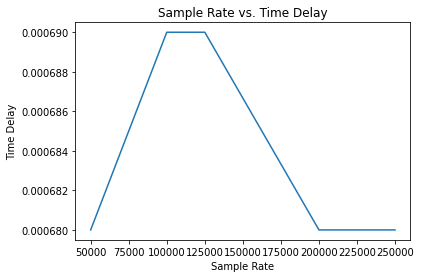

In [427]:
xdata = [5e4, 1e5, 1.25e5, 2e5, 2.5e5]

y1 = [t_delay_5e4_1[5], t_delay_1e5_1[5], t_delay_1_25e5_1[5], t_delay_2e5_1[5], t_delay_2_5e5_1[5]]
plot_line(xdata, y1, title="Sample Rate vs. Time Delay", xlabel="Sample Rate", ylabel="Time Delay")
slope, intercept, r_value, p_value, std_err = stats.linregress(xdata, y1)

y2 = [t_delay_5e4_075[5], t_delay_1e5_075[5], t_delay_1_25e5_075[5], t_delay_2e5_075[5], t_delay_2_5e5_075[5]]
plot_line(xdata, y2, title="Sample Rate vs. Time Delay", xlabel="Sample Rate", ylabel="Time Delay")
slope, intercept, r_value, p_value, std_err = stats.linregress(xdata, y2)

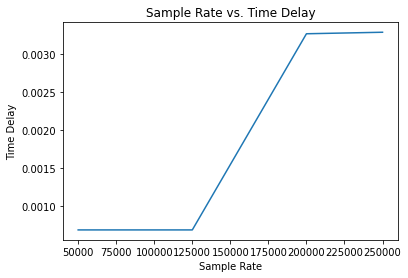

In [428]:
y3 = [t_delay_5e4_05[6], t_delay_1e5_05[6], t_delay_1_25e5_05[5], t_delay_2e5_05[5], t_delay_2_5e5_05[5]]
plot_line(xdata, y3, title="Sample Rate vs. Time Delay", xlabel="Sample Rate", ylabel="Time Delay")
slope, intercept, r_value, p_value, std_err = stats.linregress(xdata, y3)